# Haze-ard

## Section 1: Import required modules

In [283]:
from netCDF4 import Dataset
import numpy as np
import os
os.environ['PROJ_LIB']= '/usr/share/proj'
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from math import radians, cos, sin, asin, sqrt 


%matplotlib inline

## Section 2: Preprocessing

### 2.1 Import NETCDF file

In [284]:
file_loc = 'DOWNTOWN_20x20m_7d.nc4'
nc = Dataset(file_loc, mode='r')
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.3
    SIMULATION_START_DATE: 2019-06-01T00:00:00Z
    grid_projection: lonlat
    pole_lat: -90.0
    pole_lon: 0.0
    CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
    nco_openmp_thread_number: 1
    title: MEGASENSE_SILAM_SIMULATION
    source: SILAM v5_7 SVN (r590117) and MEGASENSE
    NCO: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    authors: Jonatan Hamberg<jonatan.hamberg@helsinki.fi>
John Backman<john.backman@fmi.fi>
Andres Huertas<andres.huertas@helsinki.fi>
    dimensions(sizes): time(2017), lon(80), lat(85), height(1)
    variables(dimensions): int32 time(time), float32 lon(lon), float32 lat(lat), float32 height(height), float32 fmi_no2(time,height,lat,lon), float32 fmi_no(time,height,lat,lon), float32 fmi_pm10p0(ti

### 2.2 Save different data as numpy arrays

In [285]:
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
temperature = nc.variables['fmi_temp_2m'][:] # 2 meter temperature
rel_humid = nc.variables['fmi_rel_humid'][:] # relative humidity
no2 = nc.variables['fmi_no2'][:] # NO2
pm10 = nc.variables['fmi_pm10p0'][:] # PM10 data
wind_speed = nc.variables['fmi_windspeed_10m'][:]
nc.close()

## Section 3: Print the data at a specific time

In [286]:
m = Basemap(width=10000000, height=7000000,\
        resolution='l', projection='stere',\
        lat_ts=40, lat_0=50, lon_0=0)

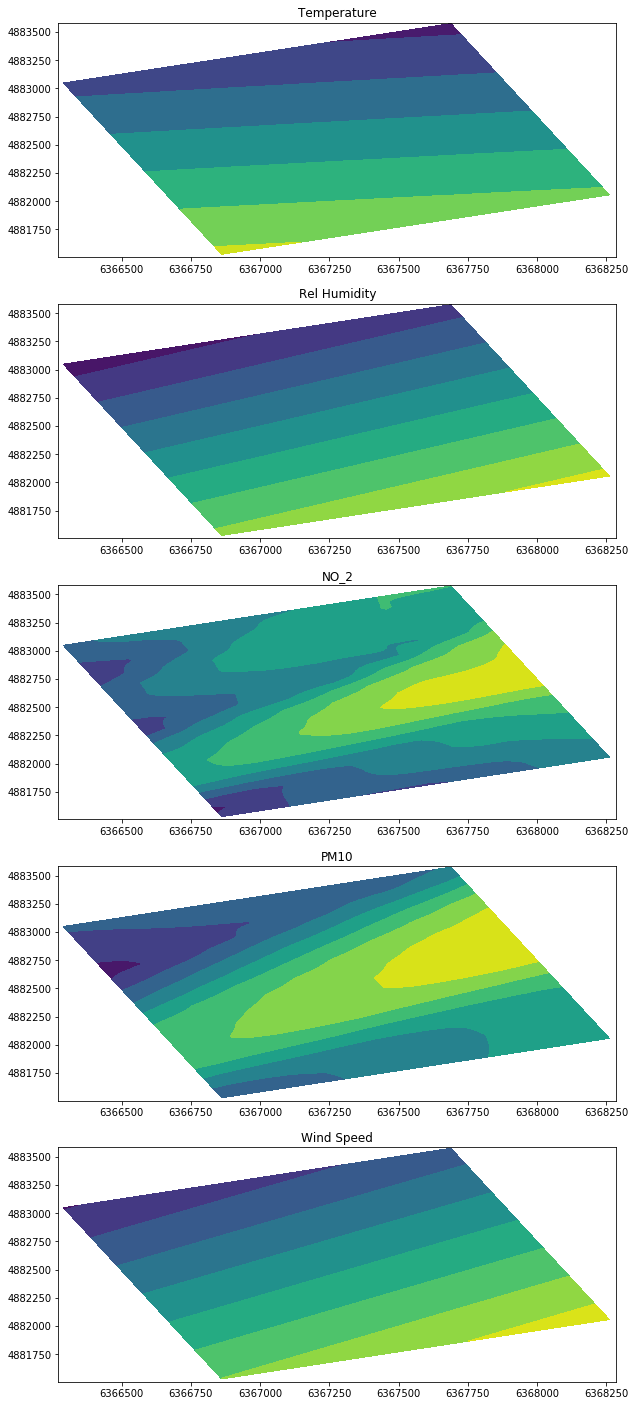

In [287]:
when = 20
temperature_when = temperature[when,:,:]
rel_humid_when = rel_humid[when,0,:,:]
no2_when = no2[when,0,:,:]
pm10_when = pm10[when,0,:,:]
wind_speed_when = wind_speed[when,:,:]

fig = plt.figure(figsize=(10,25))

plt.subplot(5,1,1)
xx, yy = np.meshgrid(lon, lat)
xx, yy = m(xx, yy)
plt.contourf(xx, yy,temperature_when)
plt.title("Temperature")

plt.subplot(5,1,2)
xx, yy = np.meshgrid(lon, lat)
xx, yy = m(xx, yy)
plt.contourf(xx, yy,rel_humid_when)
plt.title("Rel Humidity")

plt.subplot(5,1,3)
xx, yy = np.meshgrid(lon, lat)
xx, yy = m(xx, yy)
plt.contourf(xx, yy,no2_when)
plt.title("NO_2")

plt.subplot(5,1,4)
xx, yy = np.meshgrid(lon, lat)
xx, yy = m(xx, yy)
plt.contourf(xx, yy,pm10_when)
plt.title("PM10")

plt.subplot(5,1,5)
xx, yy = np.meshgrid(lon, lat)
xx, yy = m(xx, yy)
plt.contourf(xx, yy,wind_speed_when)
plt.title("Wind Speed")

## Section 4: Functions

In [295]:
def geo_idx(dd, dd_array):
    """
    Input:
        dd -> input position
        dd_array -> all possible positions
    
    Output:
        geo_idx -> the position closest to dd present in dd_array
    
    """
  
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

In [297]:
def vis_index(in_lat,in_lon,t):
    """
    Input:
        in_lat -> input lattitude
        in_lon -> input longitude
        t -> time at which we have to find visibility
    
    Output:
        idx -> visibility (in km) at in_lat and in_lot at time t
    
    """
    
    lat_idx = geo_idx(in_lat,lat)
    lon_idx = geo_idx(in_lon,lon)
    
    if(lon_idx < pm10.shape[2] and lat_idx < pm10.shape[3]):    
        idx = 0.499*(temperature[t,lon_idx,lat_idx]-273.16) - \
              0.153*(rel_humid[t,0,lon_idx,lat_idx]) - 0.038*25 + \
              wind_speed[t,lon_idx,lat_idx] - \
              0.034*no2[t,0,lon_idx,lat_idx]/1.88 - \
              1.547*np.log(pm10[t,0,lon_idx,lat_idx]) +\
              17.585
        return idx

In [298]:
def distance(lat1, lat2, lon1, lon2): 
    """
    Input:
        lat1 -> lattitude of 1st point
        lat2 -> lattitude of 2nd point
        lon1 -> longitude of 1st point
        lon2 -> longitude of 2nd point
    
    Output:
        dist -> distance in km between points 1 and 2
    
    """
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    r = 6371
    
    dist = c*r;
       
    return dist 

In [299]:
def vis_path(path,speed,start_time=0):
    """
    Input:
        path -> the pathfile with the lat and lon values
        speed -> speed of the vehicle
        start_time -> starting time 
    
    Output:
        ans -> array with visibility of each point in the path
    
    """
    
    t = start_time
    i = 0
    prev_lat = 0
    prev_lon = 0
    ans = []
    for p in path:
        in_lat = float(p.split()[1])
        in_lon = float(p.split()[0])
        if i==0:
            i = i+1;
            if(in_lat > lat.max() or in_lat < lat.min() or in_lon > lon.max() or in_lon < lon.min()):
                continue;
            ans.append(vis_index(in_lat,in_lon,t))
        else:
            dist = abs(distance(in_lat,prev_lat,in_lon,prev_lon))
            t = int(t + np.ceil((dist/speed)/3600))
            if(in_lat > lat.max() or in_lat<lat.min() or in_lon>lon.max() or in_lon<lon.min()):
                continue
            ans.append(vis_index(in_lat,in_lon,t))
            i = i+1
        prev_lat = in_lat
        prev_lon = in_lon
    return ans

## Section 5: Check the paths

In [301]:
path1 = gpd.read_file("path1.shp")
path2 = gpd.read_file("path2.shp")

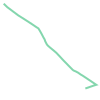

In [302]:
path1['geometry'].iloc[0]

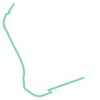

In [303]:
path2['geometry'].iloc[0]

In [304]:
p1 = path1['geometry']
p1 = p1.to_csv()[25:-3].split(',')
p2 = path2['geometry']
p2 = p2.to_csv()[25:-3].split(',')

## Section 6: Finding path visibilty

In [308]:
start_time=50
final_p1 = vis_path(p1,30,start_time)[1:-1]
final_p2 = vis_path(p2,30,start_time)[1:]

final_p1 = np.array(final_p1)
final_p1 = final_p1.reshape(final_p1.shape[0],1)
final_p2 = np.array(final_p2)
final_p2 = final_p2.reshape(final_p2.shape[0],1)

The first two columns are the lon-lat values and the third value is the visibility at that point

In [309]:
temp_p1 = np.array([x.split() for x in p1[0:12]])
temp_p1 = temp_p1.astype(np.float)
final_p1 = np.hstack((temp_p1,final_p1))
final_p1

array([[24.93907273, 60.16656585, 21.75108787],
       [24.94113497, 60.1672816 , 21.76315537],
       [24.94183837, 60.16749632, 21.68215306],
       [24.94115096, 60.16795758, 21.52073294],
       [24.93936848, 60.16915839, 21.44173884],
       [24.93833736, 60.16984228, 21.38800488],
       [24.93791372, 60.17008084, 21.34547117],
       [24.9372263 , 60.1705679 , 21.34418594],
       [24.93667877, 60.17085815, 21.38774481],
       [24.93612324, 60.17109471, 21.46576443],
       [24.93587945, 60.17127363, 21.61944421],
       [24.93531993, 60.1718382 , 21.74154045]])

In [310]:
temp_p2 = np.array([x.split() for x in p2[0:9]])
temp_p2 = temp_p2.astype(np.float)
final_p2 = np.hstack((temp_p2,final_p2))
final_p2

array([[24.93895083, 60.16651714, 21.69190028],
       [24.93806759, 60.16621492, 21.70344712],
       [24.93027423, 60.16344518, 21.80502026],
       [24.92849974, 60.16286456, 21.759493  ],
       [24.92881947, 60.16257822, 21.70708752],
       [24.92914719, 60.16238136, 21.65524684],
       [24.92930306, 60.16226603, 21.65006531],
       [24.92928707, 60.16217655, 21.7479303 ],
       [24.92887542, 60.16201349, 21.8351601 ]])